### Wstęp do projektu
Celem tego projektu jest zapewnienie analizy rynku mieszkaniowego w Nowym Jorku poprzez zestawienie ze sobą kluczowych czynników, takich jak powierzchnia, cena, rodzaj nieruchomości oraz liczba sypialni i łazienek.

Dataset został pobrany z serwisu kaggle.com: https://www.kaggle.com/datasets/nelgiriyewithana/new-york-housing-market


### Import potrzebnych bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML
import folium

### Wczytanie oraz wstępne zapoznanie się z danymi

In [2]:
# Wczytanie obrazka oraz wycentrowanie go
display(HTML('<br /><div style="text-align: center;"><img src="Images/istockphoto-615398376-612x612.jpg" alt="Alt text"></div><br />'))              
# Wczytanie danych i przypisanie ich do zmiennej nyc_data
nyc_data = pd.read_csv("NY-House-Dataset.csv")
nyc_data

# Stworzony w trakcie pracy dataset z dzielnicami które zostane wzięte do analizy.
borough = pd.read_csv("borough.csv")

In [3]:
# Kształt danych
nyc_data.shape

(4801, 17)

In [4]:
# Pierwsze informacje na temat zaimportowanych danych
nyc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4801 entries, 0 to 4800
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BROKERTITLE                  4801 non-null   object 
 1   TYPE                         4801 non-null   object 
 2   PRICE                        4801 non-null   int64  
 3   BEDS                         4801 non-null   int64  
 4   BATH                         4801 non-null   float64
 5   PROPERTYSQFT                 4801 non-null   float64
 6   ADDRESS                      4801 non-null   object 
 7   STATE                        4801 non-null   object 
 8   MAIN_ADDRESS                 4801 non-null   object 
 9   ADMINISTRATIVE_AREA_LEVEL_2  4801 non-null   object 
 10  LOCALITY                     4801 non-null   object 
 11  SUBLOCALITY                  4801 non-null   object 
 12  STREET_NAME                  4801 non-null   object 
 13  LONG_NAME         

In [5]:
# Sprawdzenie czy w danych są brakujące wartości
empty_columns = nyc_data.isnull().any(axis=0)
print("Columns with at least one blank value:\n",empty_columns)

Columns with at least one blank value:
 BROKERTITLE                    False
TYPE                           False
PRICE                          False
BEDS                           False
BATH                           False
PROPERTYSQFT                   False
ADDRESS                        False
STATE                          False
MAIN_ADDRESS                   False
ADMINISTRATIVE_AREA_LEVEL_2    False
LOCALITY                       False
SUBLOCALITY                    False
STREET_NAME                    False
LONG_NAME                      False
FORMATTED_ADDRESS              False
LATITUDE                       False
LONGITUDE                      False
dtype: bool


### Czyszczenie oraz manipulacja danymi

In [6]:
# Usunięcie kolumny pod nazwą 'BROKERTITLE'.
# Sprawdzenie czy polecenie jest wyświetlane poprawnie poprzez zastosowanie funkcji .head()

nyc_data = nyc_data.drop(columns='BROKERTITLE')
nyc_data.head(5)

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Condo for sale,315000,2,2.000000,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Condo for sale,195000000,7,10.000000,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,House for sale,260000,4,2.000000,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Condo for sale,69000,3,1.000000,445.0,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Townhouse for sale,55000000,7,2.373861,14175.0,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856


In [7]:
# Podmiana wartości podanych w stopach kwadratowych na metry kwadratowe oraz zmiana nazewnictwa kolumny.
nyc_data['PROPERTYSQFT'] = (nyc_data['PROPERTYSQFT']*0.09290304).round(2)
nyc_data = nyc_data.rename(columns={'PROPERTYSQFT':'PROPERTYSQMETERS'})
nyc_data

,TYPE,PRICE,BEDS,BATH,PROPERTYSQMETERS,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Condo for sale,315000,2,2.000000,130.06,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Condo for sale,195000000,7,10.000000,1629.98,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,House for sale,260000,4,2.000000,187.20,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Condo for sale,69000,3,1.000000,41.34,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Townhouse for sale,55000000,7,2.373861,1316.90,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,Co-op for sale,599000,1,1.000000,202.92,222 E 80th St Apt 3A,"Manhattan, NY 10075","222 E 80th St Apt 3AManhattan, NY 10075",New York,New York County,New York,Manhattan,222,"222 E 80th St #3a, New York, NY 10075, USA",40.774350,-73.955879
4797,Co-op for sale,245000,1,1.000000,202.92,97-40 62 Dr Unit Lg,"Rego Park, NY 11374","97-40 62 Dr Unit LgRego Park, NY 11374",United States,New York,Queens County,Queens,62nd Drive,"97-40 62nd Dr, Rego Park, NY 11374, USA",40.732538,-73.860152
4798,Co-op for sale,1275000,1,1.000000,202.92,427 W 21st St Unit Garden,"New York, NY 10011","427 W 21st St Unit GardenNew York, NY 10011",United States,New York,New York County,New York,West 21st Street,"427 W 21st St, New York, NY 10011, USA",40.745882,-74.003398
4799,Condo for sale,598125,2,1.000000,60.85,91-23 Corona Ave Unit 4G,"Elmhurst, NY 11373","91-23 Corona Ave Unit 4GElmhurst, NY 11373",New York,Queens County,Queens,Flushing,91-23,"91-23 Corona Ave. #4b, Flushing, NY 11373, USA",40.742770,-73.872752


In [8]:
# Zapisanie typów nieruchomości z wielkiej litery aby uniknąć pomyłek podczas stosowania 
# (wartości mogły być pomieszane jeśli chodzi o zapis, zostało to usystematyzowane)
# Pozbycie się tych samych adresów - pozostawienie wartości unikalnych
nyc_data['TYPE'] = nyc_data['TYPE'].str.upper()
nyc_data['MAIN_ADDRESS'] = nyc_data['MAIN_ADDRESS'].drop_duplicates()
nyc_data = nyc_data.dropna()
nyc_data['STATE'] = nyc_data['STATE'].str.upper()
nyc_data.reset_index(drop = True)

/var/folders/1f/2_y33jss4n75vrx4ryshkwnc0000gn/T/ipykernel_2675/3204583351.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_data['STATE'] = nyc_data['STATE'].str.upper()


,TYPE,PRICE,BEDS,BATH,PROPERTYSQMETERS,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,CONDO FOR SALE,315000,2,2.000000,130.06,2 E 55th St Unit 803,"NEW YORK, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,CONDO FOR SALE,195000000,7,10.000000,1629.98,Central Park Tower Penthouse-217 W 57th New Yo...,"NEW YORK, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,HOUSE FOR SALE,260000,4,2.000000,187.20,620 Sinclair Ave,"STATEN ISLAND, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,CONDO FOR SALE,69000,3,1.000000,41.34,2 E 55th St Unit 908W33,"MANHATTAN, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,TOWNHOUSE FOR SALE,55000000,7,2.373861,1316.90,5 E 64th St,"NEW YORK, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4578,CO-OP FOR SALE,599000,1,1.000000,202.92,222 E 80th St Apt 3A,"MANHATTAN, NY 10075","222 E 80th St Apt 3AManhattan, NY 10075",New York,New York County,New York,Manhattan,222,"222 E 80th St #3a, New York, NY 10075, USA",40.774350,-73.955879
4579,CO-OP FOR SALE,245000,1,1.000000,202.92,97-40 62 Dr Unit Lg,"REGO PARK, NY 11374","97-40 62 Dr Unit LgRego Park, NY 11374",United States,New York,Queens County,Queens,62nd Drive,"97-40 62nd Dr, Rego Park, NY 11374, USA",40.732538,-73.860152
4580,CO-OP FOR SALE,1275000,1,1.000000,202.92,427 W 21st St Unit Garden,"NEW YORK, NY 10011","427 W 21st St Unit GardenNew York, NY 10011",United States,New York,New York County,New York,West 21st Street,"427 W 21st St, New York, NY 10011, USA",40.745882,-74.003398
4581,CONDO FOR SALE,598125,2,1.000000,60.85,91-23 Corona Ave Unit 4G,"ELMHURST, NY 11373","91-23 Corona Ave Unit 4GElmhurst, NY 11373",New York,Queens County,Queens,Flushing,91-23,"91-23 Corona Ave. #4b, Flushing, NY 11373, USA",40.742770,-73.872752


In [9]:
nyc_data['TYPE'].value_counts()

TYPE
CO-OP FOR SALE                1388
HOUSE FOR SALE                 965
CONDO FOR SALE                 842
MULTI-FAMILY HOME FOR SALE     697
TOWNHOUSE FOR SALE             287
PENDING                        229
CONTINGENT                      87
LAND FOR SALE                   47
FOR SALE                        20
FORECLOSURE                     14
CONDOP FOR SALE                  4
COMING SOON                      2
MOBILE HOUSE FOR SALE            1
Name: count, dtype: int64

In [10]:
# Ze stworzonego wczesniej datasetu wyodrębiam kody pocztowe do pożądanych przeze mnie dzielnic
borough = borough[borough['BOROUGH'] != 'Queens']
l = list(borough['ZIP CODE'])
location = [str(ZIP) for ZIP in l]
location

['10001',
 '10001',
 '10002',
 '10002',
 '10003',
 '10003',
 '10004',
 '10004',
 '10005',
 '10005',
 '10006',
 '10006',
 '10007',
 '10007',
 '10009',
 '10009',
 '10010',
 '10010',
 '10011',
 '10011',
 '10012',
 '10012',
 '10013',
 '10013',
 '10014',
 '10014',
 '10015',
 '10015',
 '10016',
 '10016',
 '10017',
 '10017',
 '10018',
 '10018',
 '10019',
 '10019',
 '10020',
 '10020',
 '10021',
 '10021',
 '10022',
 '10022',
 '10023',
 '10023',
 '10024',
 '10024',
 '10025',
 '10025',
 '10026',
 '10026',
 '10027',
 '10027',
 '10028',
 '10028',
 '10029',
 '10029',
 '10030',
 '10030',
 '10031',
 '10031',
 '10032',
 '10032',
 '10033',
 '10033',
 '10034',
 '10034',
 '10035',
 '10035',
 '10036',
 '10036',
 '10037',
 '10037',
 '10038',
 '10038',
 '10039',
 '10039',
 '10040',
 '10040',
 '10041',
 '10041',
 '10044',
 '10044',
 '10045',
 '10045',
 '10048',
 '10048',
 '10055',
 '10055',
 '10060',
 '10060',
 '10069',
 '10069',
 '10090',
 '10090',
 '10095',
 '10095',
 '10098',
 '10098',
 '10099',
 '10099',


In [11]:
# Stworzenie datasetu który zawiera tylko nieruchomość 'CO-OP FOR SALE' oraz kopii df który będzie używany do dalszych analiz
coop = ['CO-OP FOR SALE']
df = nyc_data[nyc_data["TYPE"].isin(coop)]
df_copy = df.copy()

In [12]:
# Zostawienie w kolumnie STATE tylko samych kodów pocztowych oraz przefiltrowanie danych przez żądaną lokalizację
df['STATE'] = df['STATE'].str.extract(r'(\d{5})')
df = df[df["STATE"].isin(location)]

/var/folders/1f/2_y33jss4n75vrx4ryshkwnc0000gn/T/ipykernel_2675/4034283856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['STATE'] = df['STATE'].str.extract(r'(\d{5})')


In [13]:
df.reset_index(drop = True)

,TYPE,PRICE,BEDS,BATH,PROPERTYSQMETERS,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,CO-OP FOR SALE,265000,1,1.000000,69.68,875 Morrison Ave Apt 3M,10473,"875 Morrison Ave Apt 3MBronx, NY 10473",Bronx County,The Bronx,East Bronx,Morrison Avenue,Parking lot,"Parking lot, 875 Morrison Ave #3m, Bronx, NY 1...",40.821586,-73.874089
1,CO-OP FOR SALE,440000,2,1.000000,90.86,1350 Ocean Pkwy Apt 5G,11230,"1350 Ocean Pkwy Apt 5GBrooklyn, NY 11230",New York,Kings County,Brooklyn,Midwood,1350,"1350 Ocean Pkwy #5g, Brooklyn, NY 11230, USA",40.615738,-73.969694
2,CO-OP FOR SALE,375000,2,1.000000,78.97,800 Grand Concourse Apt 2JS,10451,"800 Grand Concourse Apt 2JSBronx, NY 10451",New York,Bronx County,The Bronx,Concourse Village,800,"800 Grand Concourse #2j, Bronx, NY 10451, USA",40.824870,-73.922983
3,CO-OP FOR SALE,895000,3,1.000000,202.92,61 Jane St Apt 6N,10014,"61 Jane St Apt 6NNew York, NY 10014",New York,New York County,New York,Manhattan,61,"61 Jane St #6n, New York, NY 10014, USA",40.738298,-74.005890
4,CO-OP FOR SALE,199000,3,1.000000,30.19,9430 Ridge Blvd Apt 6D,11209,"9430 Ridge Blvd Apt 6DBrooklyn, NY 11209",New York,Kings County,Brooklyn,Fort Hamilton,9430,"9430 Ridge Blvd #6d, Brooklyn, NY 11209, USA",40.618103,-74.036905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,CO-OP FOR SALE,4750000,3,2.373861,275.83,1175 Park Ave Unit 1C,10128,"1175 Park Ave Unit 1CNew York, NY 10128",New York,New York County,New York,Manhattan,1175,"1175 Park Ave #1c, New York, NY 10128, USA",40.784392,-73.953840
897,CO-OP FOR SALE,370000,3,1.000000,202.92,342 E 53rd St Apt 6C,10022,"342 E 53rd St Apt 6CNew York, NY 10022",New York,New York County,New York,Manhattan,342,"342 E 53rd St #6c, New York, NY 10022, USA",40.755822,-73.965514
898,CO-OP FOR SALE,1950000,2,4.000000,202.92,700 Park Ave Unit 20A,10021,"700 Park Ave Unit 20ANew York, NY 10021",New York,New York County,New York,Manhattan,700,"700 Park Ave #20a, New York, NY 10021, USA",40.769478,-73.965389
899,CO-OP FOR SALE,1275000,1,1.000000,202.92,427 W 21st St Unit Garden,10011,"427 W 21st St Unit GardenNew York, NY 10011",United States,New York,New York County,New York,West 21st Street,"427 W 21st St, New York, NY 10011, USA",40.745882,-74.003398


In [14]:
# Obliczenie średniej, odchylenia standardowego, minimalnej oraz maksymalnej wartości dla wybranych kolumn.
# Daje nam to generalny pogląd jak rozkładają się dane.
df_f = df[['PRICE','BEDS','BATH','PROPERTYSQMETERS']]
df_f.describe()

,PRICE,BEDS,BATH,PROPERTYSQMETERS
count,9.010000e+02,901.000000,901.000000,901.000000
mean,1.218831e+06,2.033296,1.487921,150.862075
std,2.745813e+06,0.980363,0.864558,75.467399
min,4.950000e+04,1.000000,1.000000,23.230000
25%,3.000000e+05,1.000000,1.000000,79.620000
50%,5.450000e+05,2.000000,1.000000,202.920000
75%,9.990000e+05,3.000000,2.000000,202.920000
max,4.800000e+07,6.000000,8.000000,696.770000


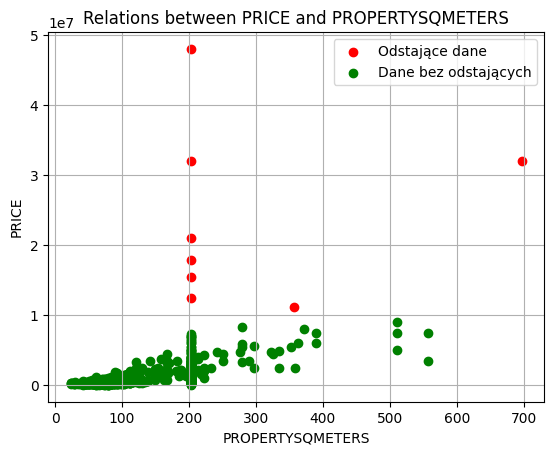

In [15]:
# Obliczenie odchylenia standardowego dla cen
mean_price = df['PRICE'].mean()
std_dev_price = df['PRICE'].std()

# Kryterium 3 sigma dla danych odstających
criterion = mean_price + 3 * std_dev_price

# Indeksy danych odstających
outliers_indices = df[df['PRICE'] > criterion].index

# Wyszczególnienie danych odstających
plt.scatter(df.loc[outliers_indices, 'PROPERTYSQMETERS'], df.loc[outliers_indices, 'PRICE'], color='red', label='Odstające dane')

# Usunięcie danych odstających
df_filtered = df.drop(outliers_indices)
plt.scatter(df_filtered['PROPERTYSQMETERS'], df_filtered['PRICE'], color='green', label='Dane bez odstających')

# Dodanie tytułu i etykiet osi
plt.title('Relations between PRICE and PROPERTYSQMETERS')
plt.xlabel('PROPERTYSQMETERS')
plt.ylabel('PRICE')
plt.legend()
plt.grid(True)
plt.show()


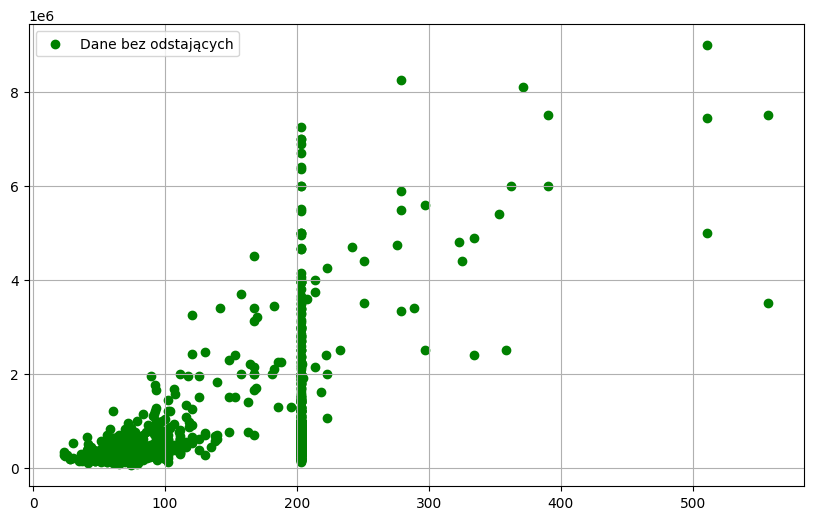

In [16]:
# Przedstawienie wyników pomijając wartości odstające.
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['PROPERTYSQMETERS'], df_filtered['PRICE'], color='green', label='Dane bez odstających')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
# Zliczenie ile wartości jest w danych metrażach 
df['PROPERTYSQMETERS'].value_counts()

PROPERTYSQMETERS
202.92    421
74.32      33
69.68      29
83.61      27
78.97      24
         ... 
93.83       1
76.37       1
79.34       1
66.89       1
275.83      1
Name: count, Length: 174, dtype: int64

In [18]:
state = borough['BOROUGH'][borough['BOROUGH'] != 'Queens']
st = list(set(borough['BOROUGH']))
b = [str(B) for B in st]
b
STATE = []
for element in b:
    STATE.append(element.upper())
STATE

['STATEN ISLAND', 'BRONX', 'MANHATTAN', 'BROOKLYN']

In [19]:
df_borough = df_copy
df_borough['STATE'] = df_borough['STATE'].str.split(',').str[0]
df_borough = df_borough[df_borough["STATE"].isin(STATE)]
df_borough.reset_index(drop=True)

,TYPE,PRICE,BEDS,BATH,PROPERTYSQMETERS,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,CO-OP FOR SALE,265000,1,1.0,69.68,875 Morrison Ave Apt 3M,BRONX,"875 Morrison Ave Apt 3MBronx, NY 10473",Bronx County,The Bronx,East Bronx,Morrison Avenue,Parking lot,"Parking lot, 875 Morrison Ave #3m, Bronx, NY 1...",40.821586,-73.874089
1,CO-OP FOR SALE,440000,2,1.0,90.86,1350 Ocean Pkwy Apt 5G,BROOKLYN,"1350 Ocean Pkwy Apt 5GBrooklyn, NY 11230",New York,Kings County,Brooklyn,Midwood,1350,"1350 Ocean Pkwy #5g, Brooklyn, NY 11230, USA",40.615738,-73.969694
2,CO-OP FOR SALE,375000,2,1.0,78.97,800 Grand Concourse Apt 2JS,BRONX,"800 Grand Concourse Apt 2JSBronx, NY 10451",New York,Bronx County,The Bronx,Concourse Village,800,"800 Grand Concourse #2j, Bronx, NY 10451, USA",40.824870,-73.922983
3,CO-OP FOR SALE,199000,3,1.0,30.19,9430 Ridge Blvd Apt 6D,BROOKLYN,"9430 Ridge Blvd Apt 6DBrooklyn, NY 11209",New York,Kings County,Brooklyn,Fort Hamilton,9430,"9430 Ridge Blvd #6d, Brooklyn, NY 11209, USA",40.618103,-74.036905
4,CO-OP FOR SALE,350000,1,1.0,65.03,5800 Arlington Ave Apt 21A,BRONX,"5800 Arlington Ave Apt 21ABronx, NY 10471",New York,Bronx County,The Bronx,North Riverdale,5800,"5800 Arlington Ave Apt 21s, Bronx, NY 10471, USA",40.907370,-73.906558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,CO-OP FOR SALE,550000,3,1.0,202.92,201 E 21st St Apt 2H,MANHATTAN,"201 E 21st St Apt 2HManhattan, NY 10010",New York,New York County,New York,Manhattan,201,"201 E 21st St #2b, New York, NY 10010, USA",40.737546,-73.983696
571,CO-OP FOR SALE,189000,3,1.0,27.87,460 Ovington Ave Apt 2H,BROOKLYN,"460 Ovington Ave Apt 2HBrooklyn, NY 11209",New York,Kings County,Brooklyn,Bay Ridge,460,"460 Ovington Ave #2h, Brooklyn, NY 11209, USA",40.632771,-74.022251
572,CO-OP FOR SALE,370000,1,1.0,63.17,850 Saint Marks Ave Apt 2J,BROOKLYN,"850 Saint Marks Ave Apt 2JBrooklyn, NY 11213",New York,Kings County,Brooklyn,Crown Heights,850,"850 St Marks Ave #2j, Brooklyn, NY 11213, USA",40.674716,-73.944828
573,CO-OP FOR SALE,599000,1,1.0,202.92,222 E 80th St Apt 3A,MANHATTAN,"222 E 80th St Apt 3AManhattan, NY 10075",New York,New York County,New York,Manhattan,222,"222 E 80th St #3a, New York, NY 10075, USA",40.774350,-73.955879


In [20]:
# Średnia cena nieruchomości w zależności od dzielnicy
df_borough
average_prices = df_borough.groupby('STATE')['PRICE'].mean().apply(lambda x: '{:,.2f}'.format(x))
average_prices

STATE
BRONX              286,139.89
BROOKLYN           456,990.21
MANHATTAN        1,973,630.90
STATEN ISLAND      333,625.00
Name: PRICE, dtype: object

In [21]:
# Stworzenie mapy Nowego Jorku
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Przypisanie kolorów do różnych zakresów cen
def pick_color(price):
    if price <= 500000:
        return 'blue'
    elif price <= 1000000:
        return 'green'
    elif price <= 5000000:
        return 'yellow'
    else:
        return 'red'

# Dodanie znaczników dla każdej nieruchomości z przypisanymi kolorami
for _, row in df.iterrows():
    tooltip_text = f"{row['TYPE']}: {row['PRICE']} - USD" 
    color = pick_color(row['PRICE'])
    folium.CircleMarker(location=(row['LATITUDE'], row['LONGITUDE']), popup=row['MAIN_ADDRESS'], tooltip=tooltip_text, radius=5, color=color, fill=True, fill_color=color).add_to(nyc_map)

nyc_map


### Wnioski

1. Podczas analizy nieruchomości 'CO-OP FOR SALE' możemy dostrzec, iż istnieje 421 mieszkań o dokładnej powierzchni 202.92 m² (2184.207862sqft) . Tak precyzyjny wynik może wskazywać na pewne oszacowanie wartości, co sugeruje obecność ludzkiej ręki w procesie zbierania danych.
2. Manhattan wyróżnia się jako dzielnica o najwyższych średnich cenach nieruchomości. Jest to zgodne z popularnym przekonaniem o wysokim koszcie życia w tym rejonie Nowego Jorku. Brooklyn, mimo że ma niższe ceny niż Manhattan, przewyższa kolejne dzielnice pod względem średniej ceny. Najtańsze nieruchomości możemy znaleźć w dzielnicy Bronx.
3. Możemy zauważyć że co najmniej do jedenego z adresów zostały podane złe współrzędne, wykraczają poza analizowane dzielnice (Manhattan, Brooklyn, Bronx, Staten Island).